In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from tqdm import tqdm

import sys
sys.path.append("../src")

from data_prep import *
from make_cuts import *
from fitting_functions import *
from pulse_profile_generator import *
from plot_maker import *
from pulse_plot_maker import *

In [2]:
pd.set_option('display.max_columns', None)

In [15]:
c_folder="../../data/calibration/"
d_folder="../../data/runData/"
r_n=300
pulsed=False

Path("../../plots").mkdir(parents=True, exist_ok=True)
Path("../../plots/run_"+str(r_n)).mkdir(parents=True, exist_ok=True)
p_folder="../../plots/run_"+str(r_n)+"/"

In [16]:
%%time
p,m,r=import_data(c_folder,d_folder, r_n, is_it_pulsed=pulsed)

CPU times: user 11.9 s, sys: 6.48 s, total: 18.4 s
Wall time: 19.3 s


In [17]:
%%time
r=select_bars_with_data(r,p, subtract_pedestal=True, is_it_pulsed=pulsed) #this needs to be run as it's own cell

Number of events: 71416


Initial pedestal-based selection performed.
Events left: 71415


CPU times: user 1.6 s, sys: 1.37 s, total: 2.96 s
Wall time: 2.97 s


(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00,
        3.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00, 3.00000e+00,
        2.00000e+00, 5.00000e+00, 2.00000e+00, 3.00000e+00, 1.00000e+01,
        1.30000e+01, 1.60000e+01, 1.20000e+01, 8.00000e+00, 1.30000e+01,
        1.40000e+01, 9.00000e+00, 1.20000e+01, 3.10000e+01, 3.70000e+01,
        4.70000e+01, 1.09000e+02, 1.34000e+02, 2.27000e+02, 3.10000e+02,
        4.90000e+02, 7.03000e+02, 1.03700e+03, 1.48500e+03, 1.94500e+03,
        2.18200e+03, 2.63600e+03, 2.83800e+03, 3.57800e+03, 5.34200e+03,
        8.26500e+03, 1.28150e+04, 2.35320e+04, 2.73540e+04, 3.80750e+04,
        6.41740e+04, 1.19336e+05, 2.66827e+05, 6.20709e+05, 3.46363e+05,
        1.34435e+05, 6.84840e+04, 4.20740e+04, 3.10080e+04, 2.78750e+04,
        1.73330e+04, 1.29690e+04, 9.47500e+03, 8.95800e+03, 6.57500e+03,
        4.31300e+03, 3.00000e+03, 2.14400e+03, 1.58500e+03, 1.18600e+03,
        8.54000e+02, 6.89000e+02, 4.93000e+02, 4.15

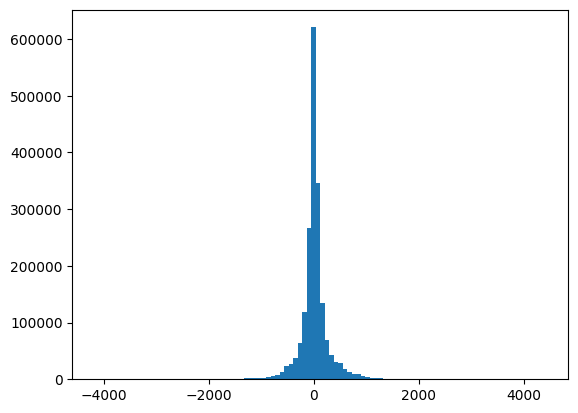

In [19]:
plt.hist(r["adc_sum_end0"]-r["adc_sum_end1"], bins=100)
# plt.ylim(0,50)

In [43]:
sick_bar=r[(r["layer"]==16) & (r["strip"]==9)]

In [25]:
# can only be ran if pulsed==True
# plot_pulse(4,r, p_folder,False)

In [7]:
# dropping unnecessary columns
r=pulse_drop_extra_cols(r, pulsed)

In [27]:
pulse_df=pd.read_csv(d_folder+"run_"+str(r_n)+"_pulse_problems.csv", index_col="index")

In [28]:
big_df=r.merge(pulse_df, left_index=True, right_index=True)

In [44]:
sick_bar_df=sick_bar.merge(pulse_df, left_index=True, right_index=True)

In [49]:
weird_stuff_indices=sick_bar_df[sick_bar_df["has_problem"]==1].index

In [53]:
sick_bar_df.rename(columns={'layer_y': 'layer'}, inplace=True)

SPIKE_0


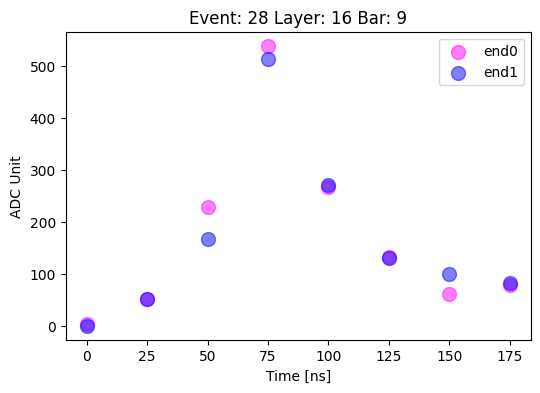

SPIKE_1


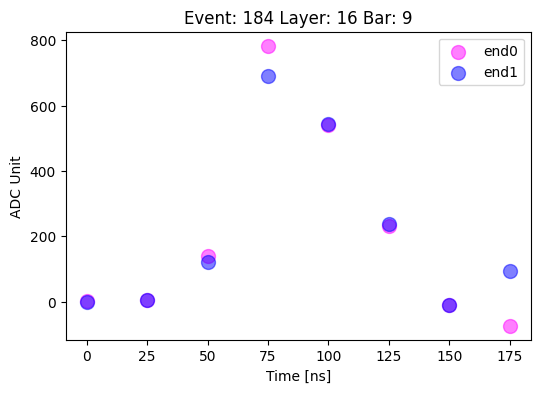

SPIKE_0


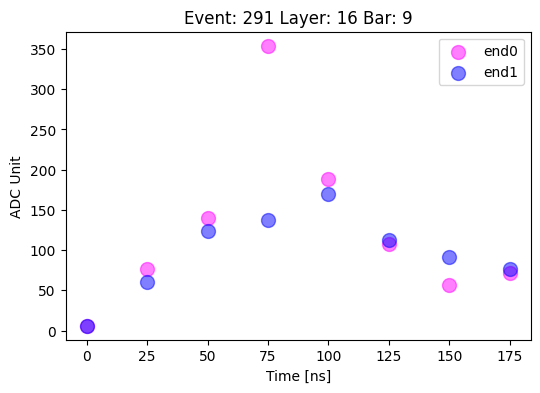

SPIKE_0


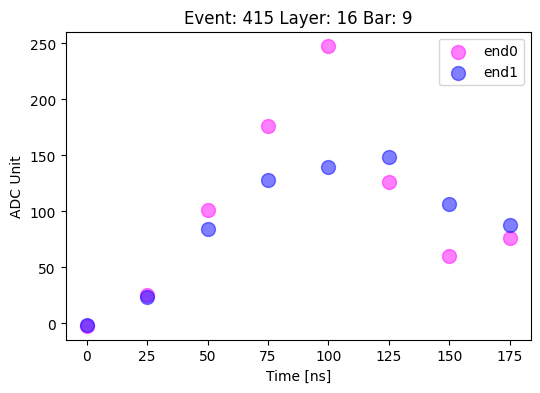

SPIKE_0


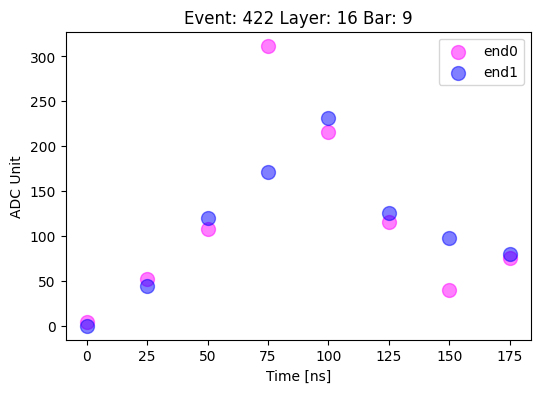

SPIKE_0


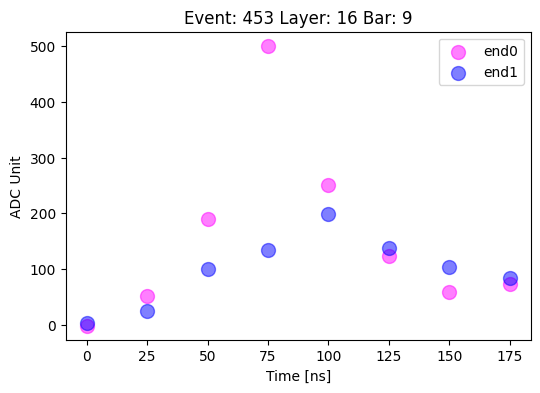

SPIKE_0


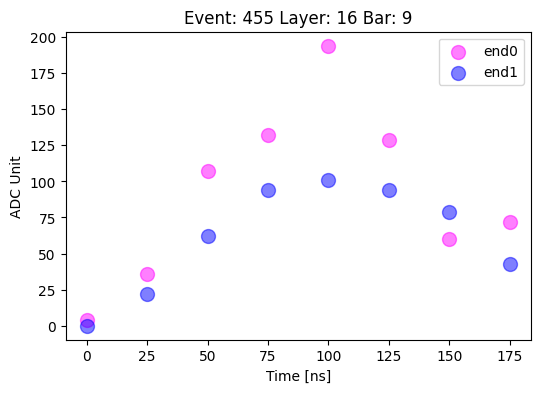

SPIKE_0


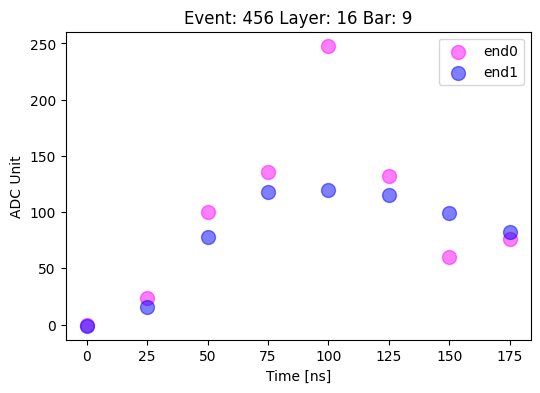

SPIKE_0


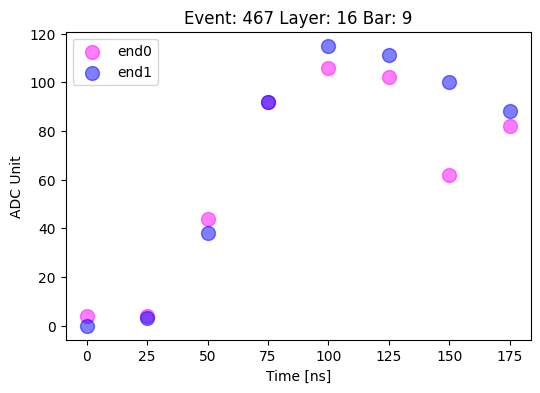

SPIKE_0


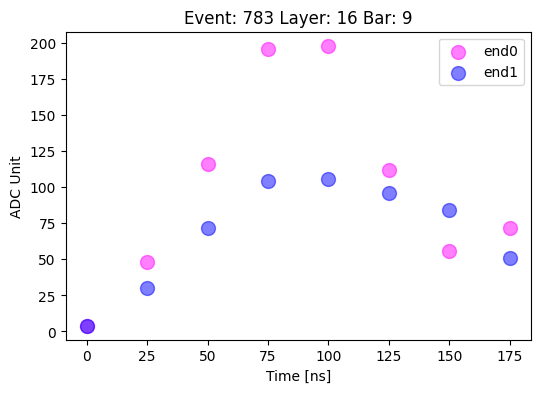

SPIKE_0


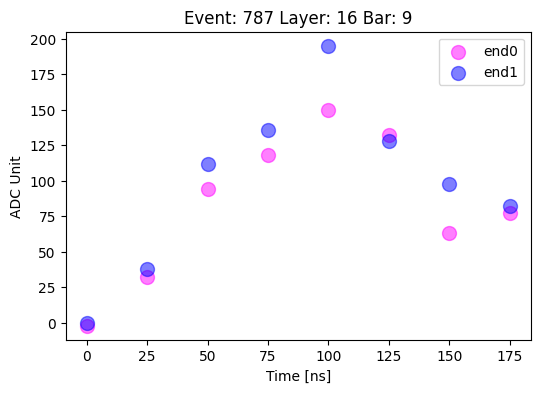

SPIKE_0


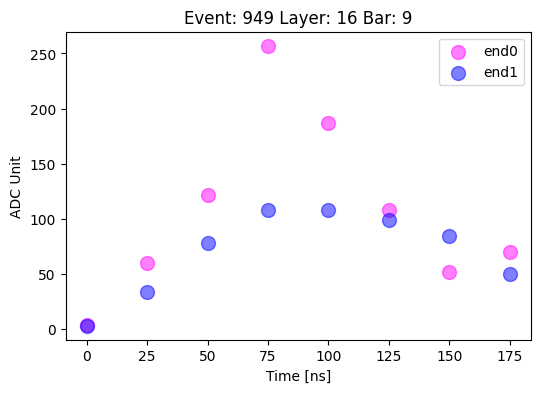

SPIKE_0


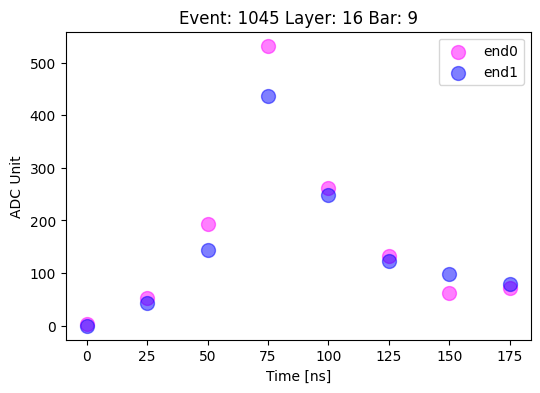

SPIKE_0


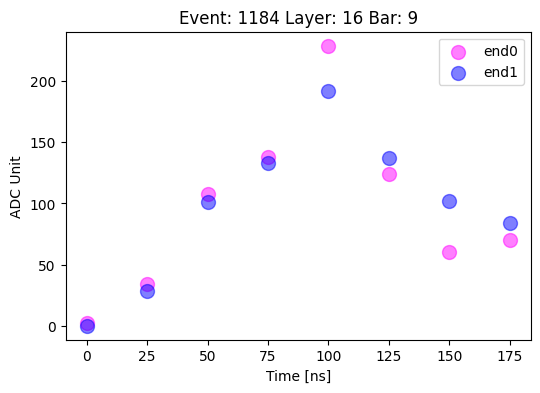

SPIKE_0


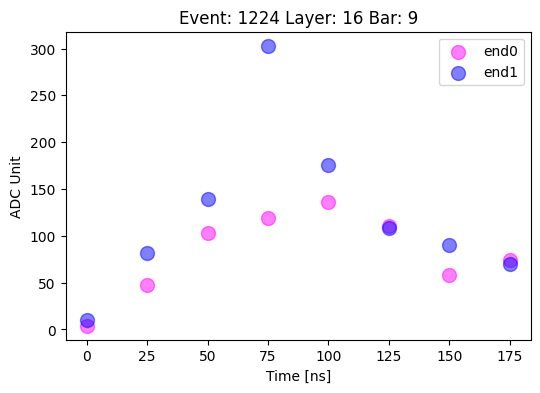

SPIKE_0


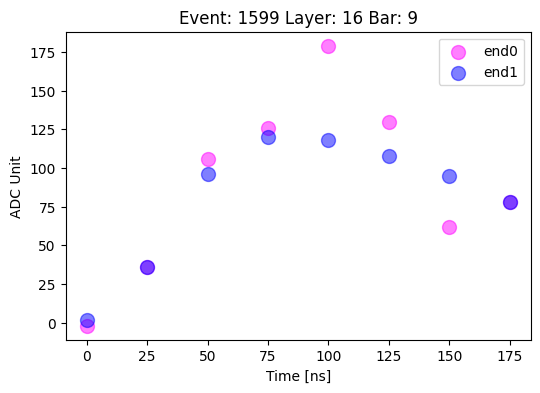

SPIKE_0


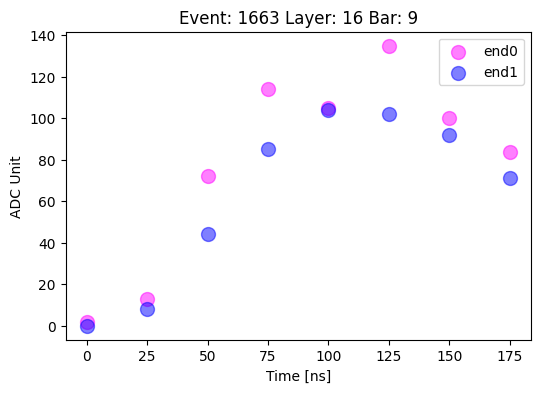

SPIKE_0


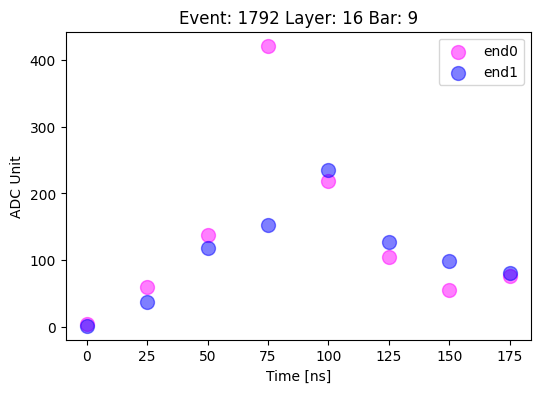

SPIKE_0


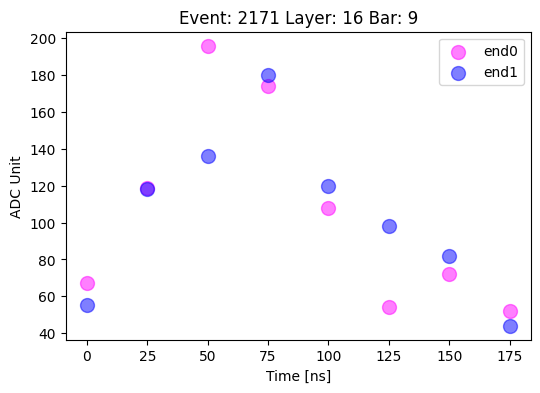

SPIKE_0


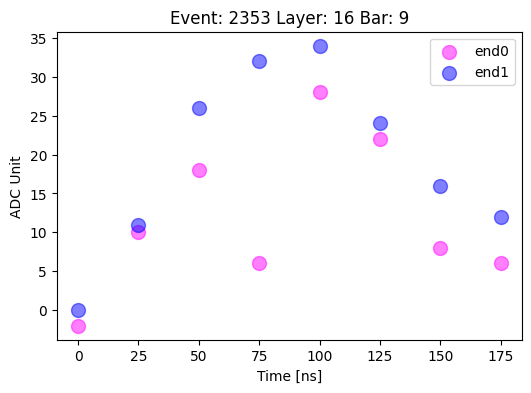

SPIKE_0


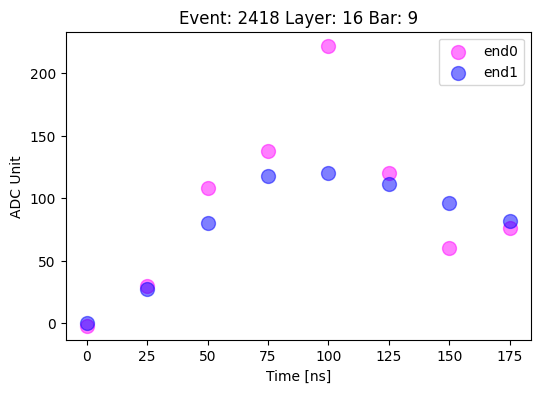

SPIKE_0


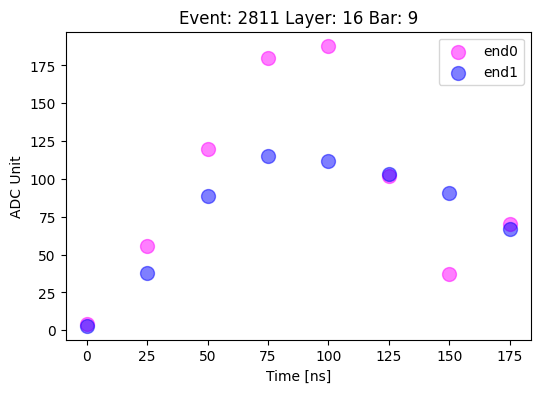

SPIKE_0


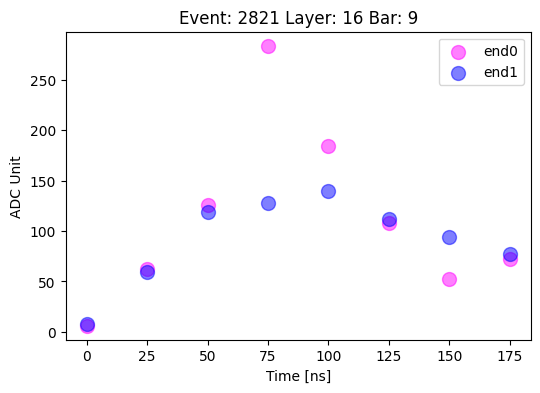

SPIKE_0


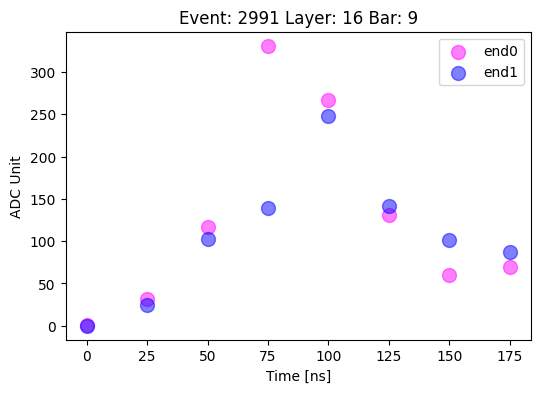

SPIKE_0


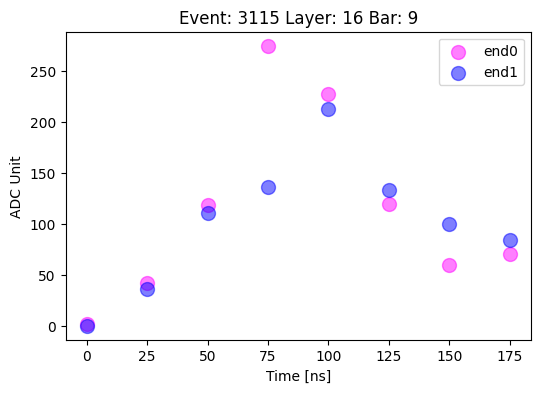

SPIKE_0


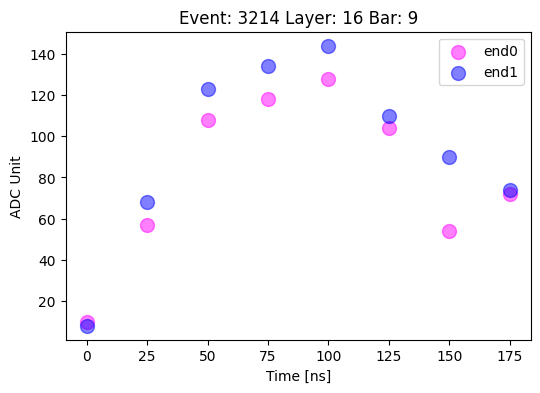

SPIKE_0


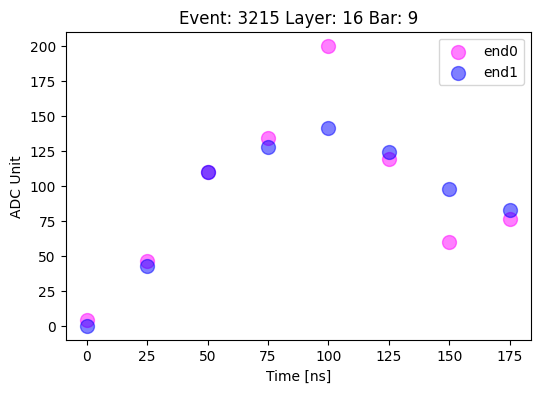

SPIKE_0


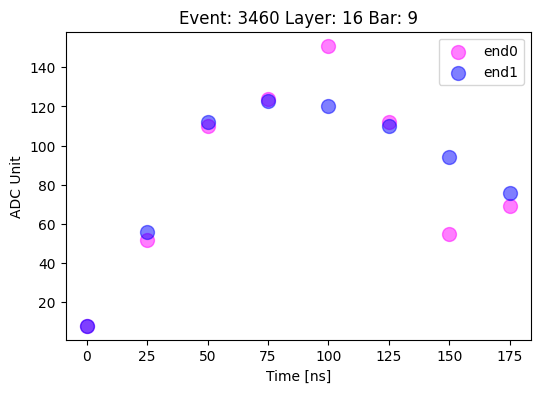

SPIKE_0


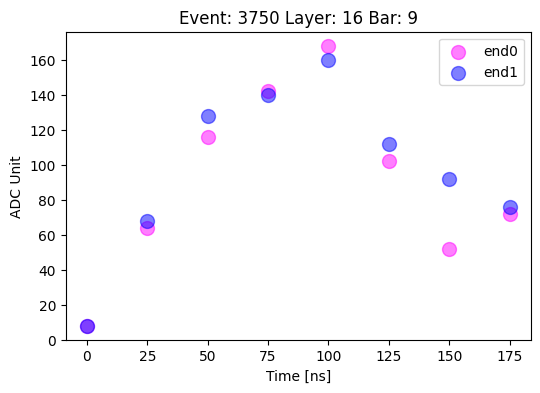

WAVE


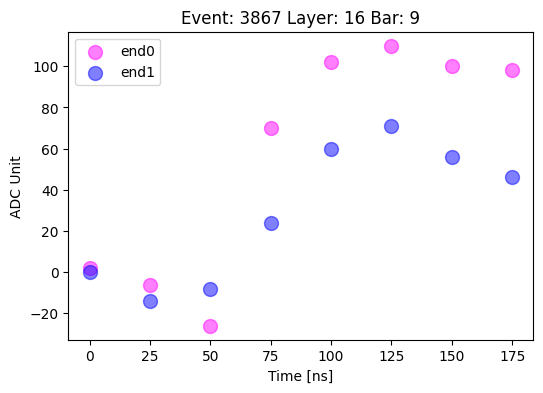

SPIKE_0


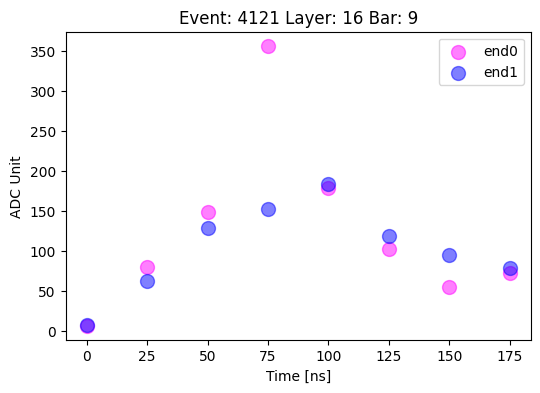

SPIKE_0


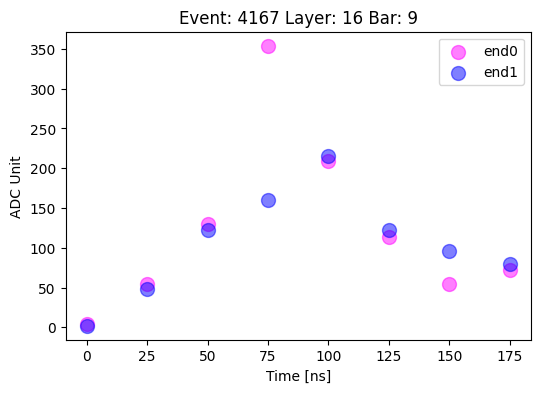

SPIKE_0


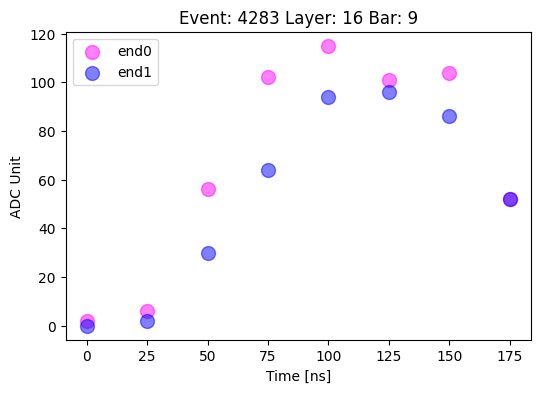

SPIKE_0


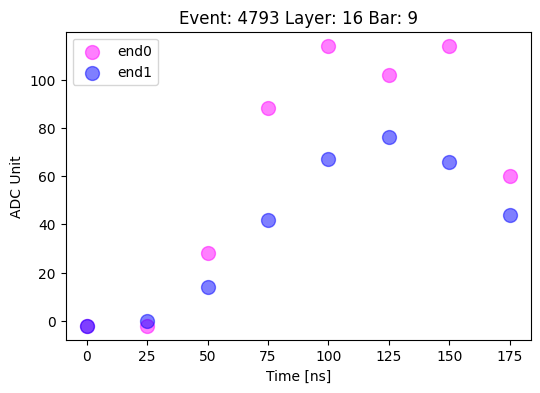

SPIKE_0


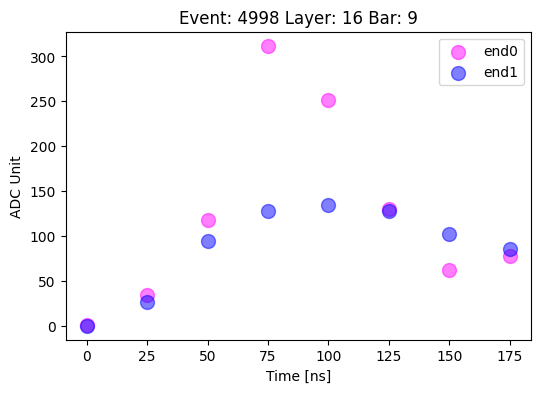

SPIKE_0


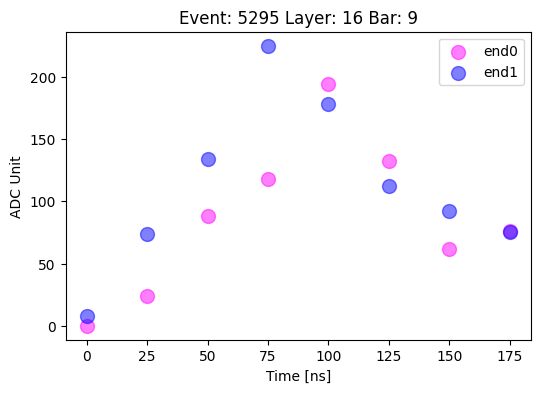

SPIKE_0


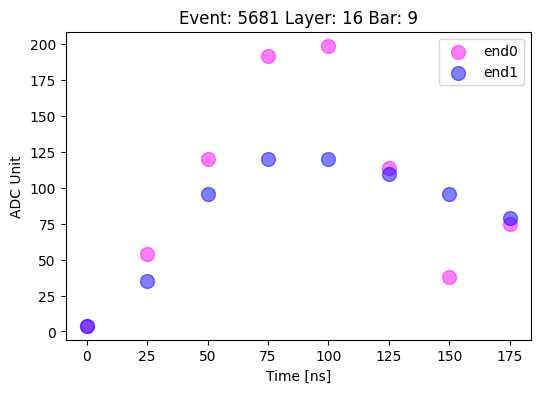

SPIKE_0


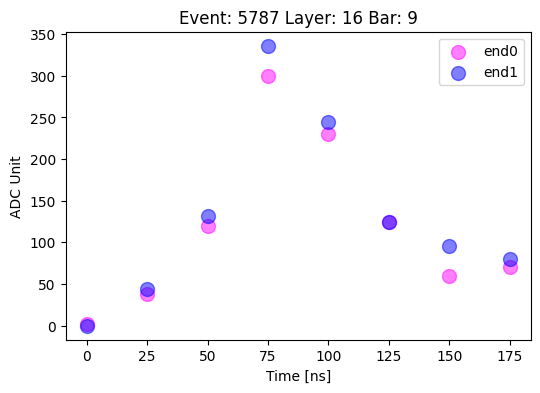

SPIKE_0


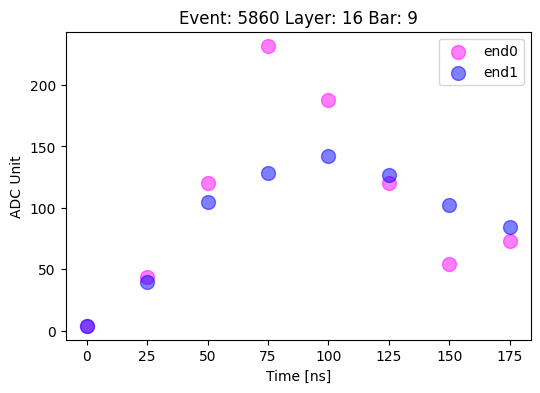

SPIKE_0


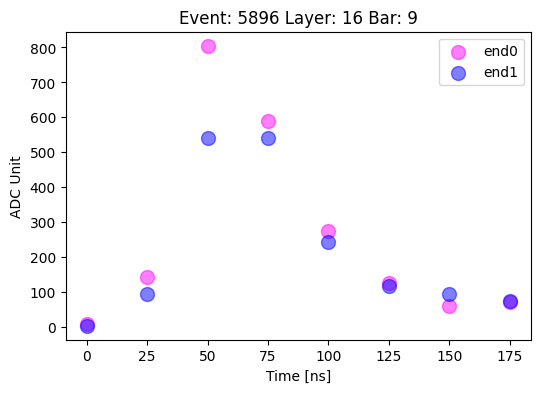

SPIKE_0


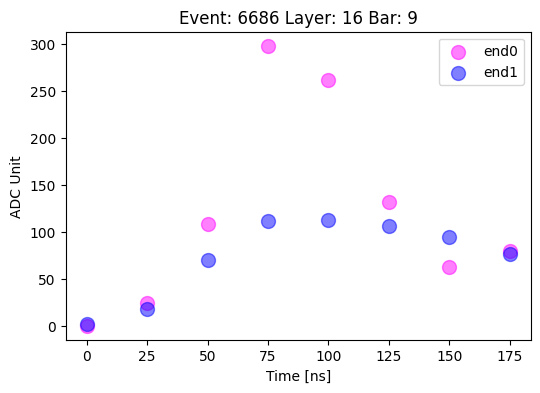

SPIKE_1


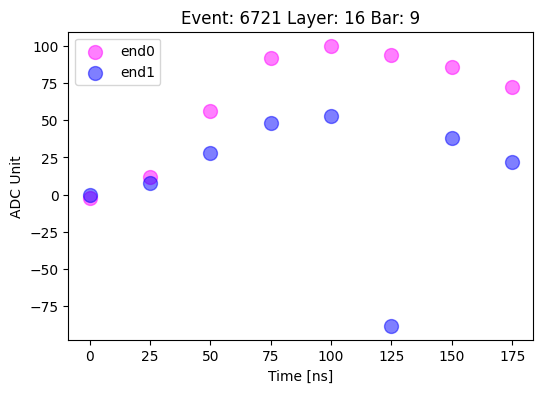

SPIKE_0


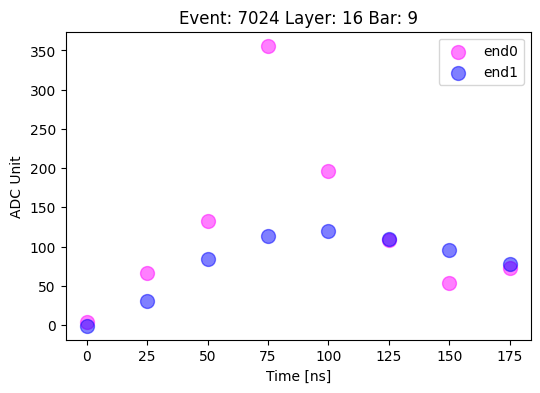

SPIKE_0


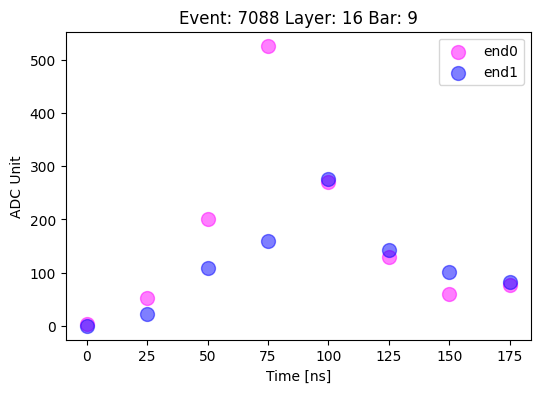

SPIKE_0


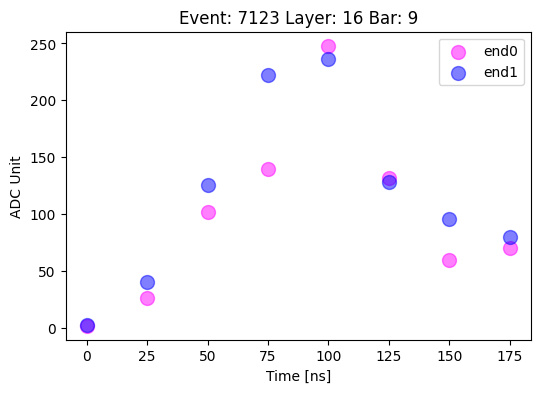

SPIKE_0


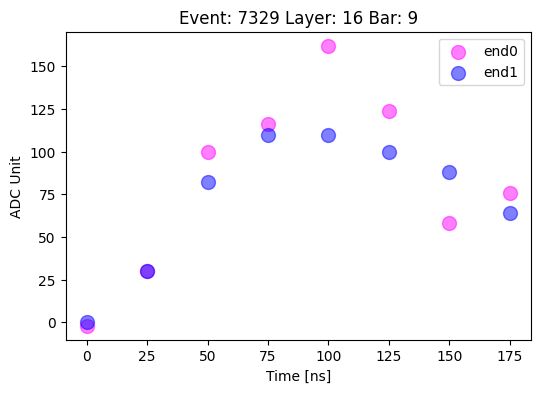

SPIKE_0


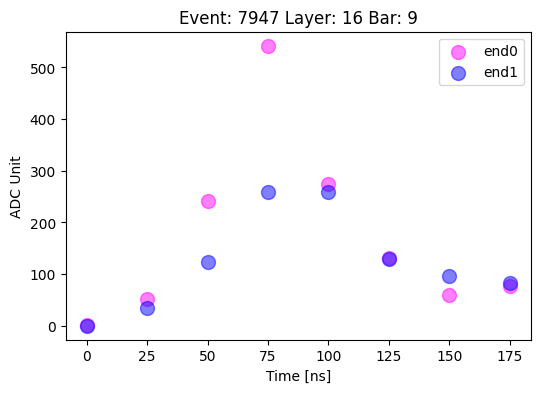

SPIKE_0


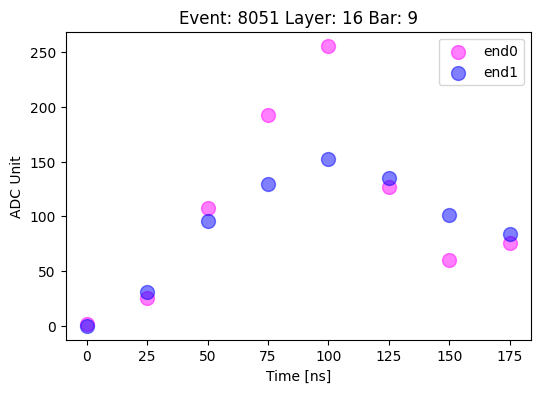

SPIKE_0


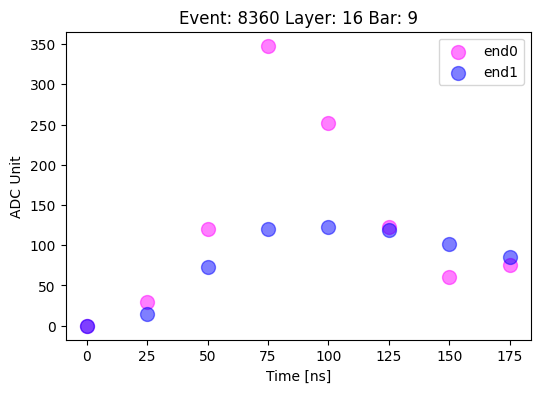

SPIKE_0


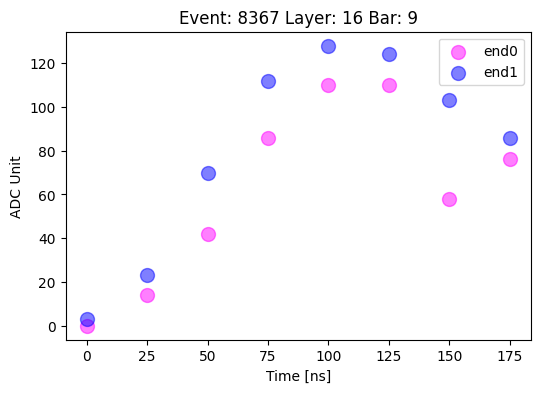

WAVE


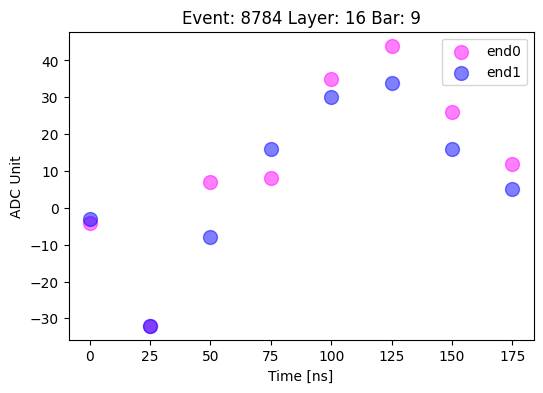

SPIKE_0


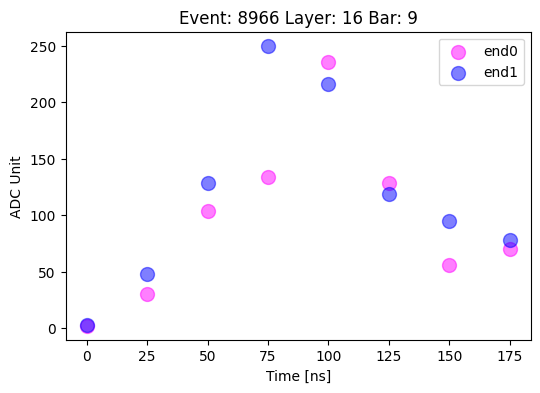

SPIKE_0


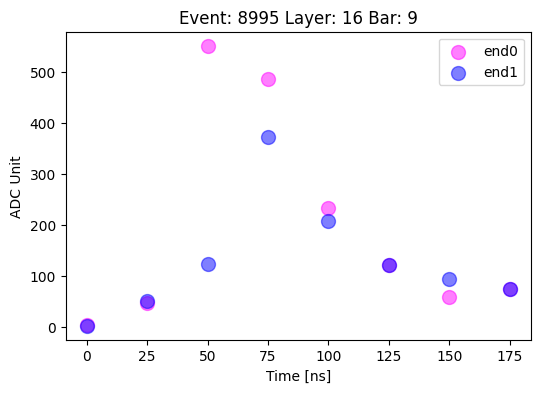

SPIKE_0


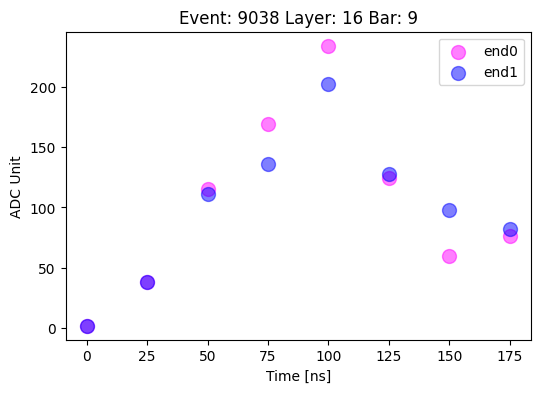

SPIKE_0


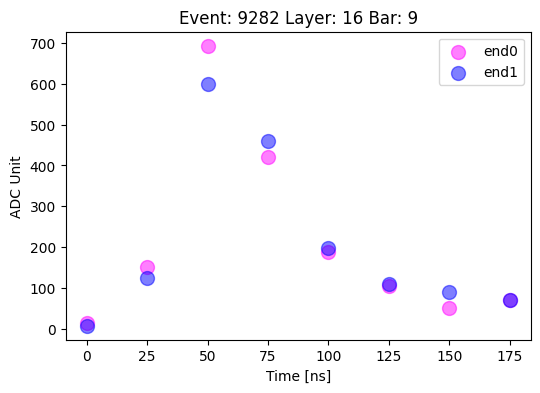

SPIKE_0


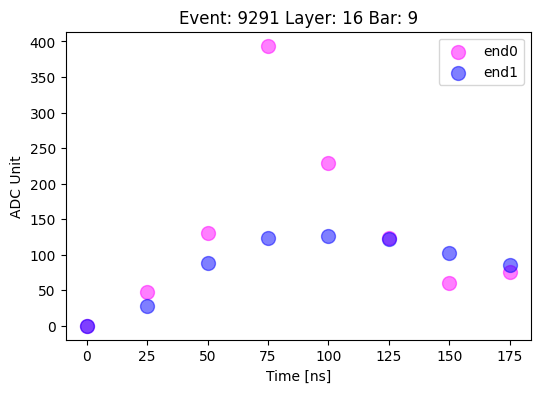

SPIKE_1


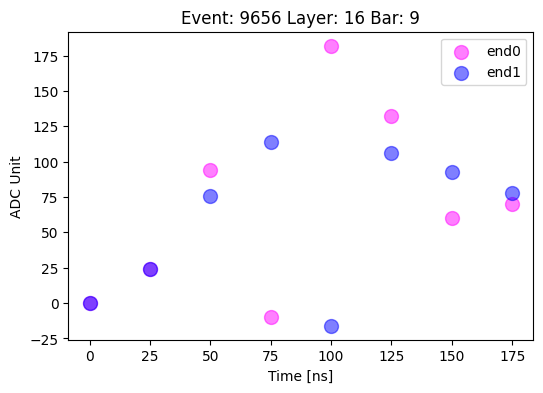

LATE


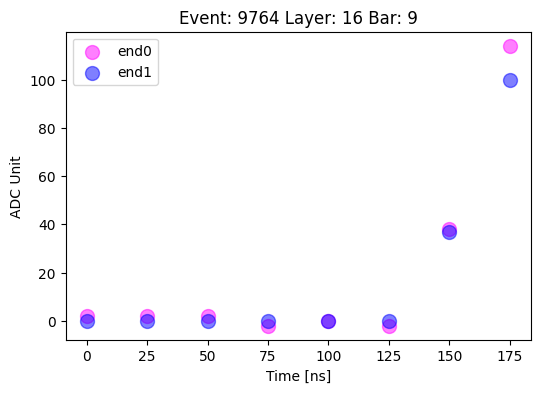

SPIKE_0


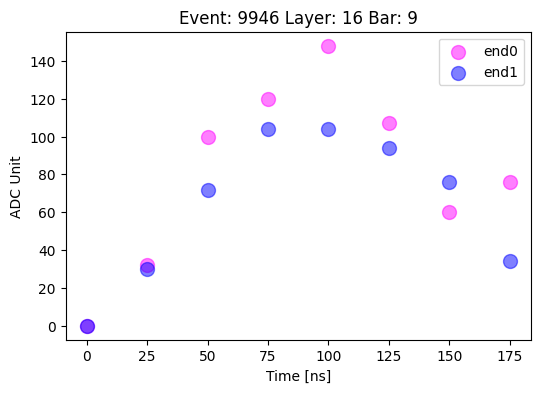

In [57]:
plt.rcParams["figure.figsize"]=(6,4)
for i in weird_stuff_indices:
    print(sick_bar_df.loc[i]["problem_type"])
    plot_pulse(i,sick_bar_df,False)

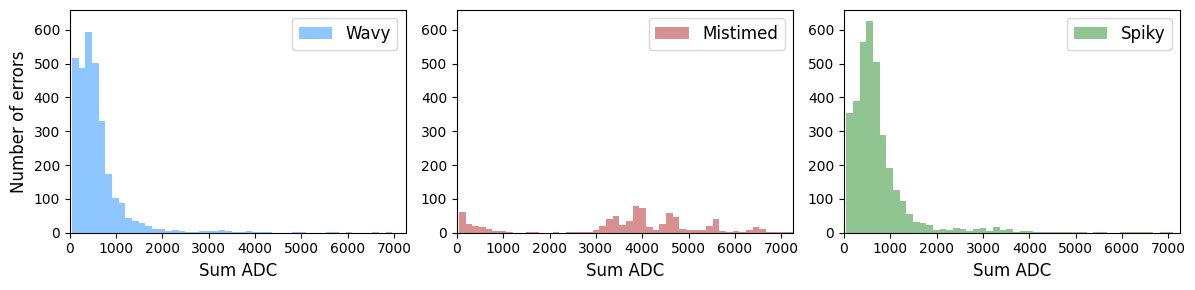

In [29]:
plot_error_by_energy(big_df, False,p_folder, False)

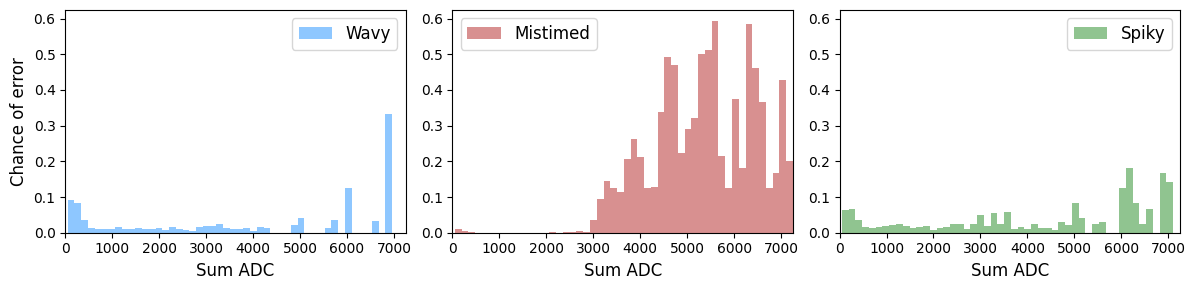

In [30]:
plot_error_by_energy(big_df, True,p_folder, False)

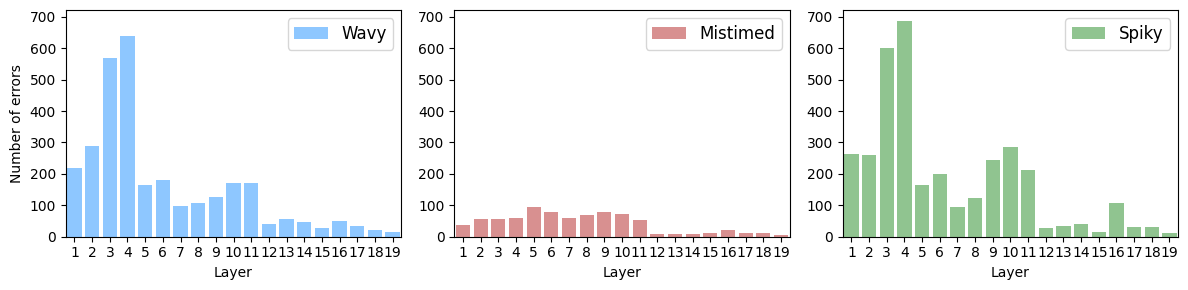

In [31]:
plot_error_by_layer(big_df, False, p_folder,False)

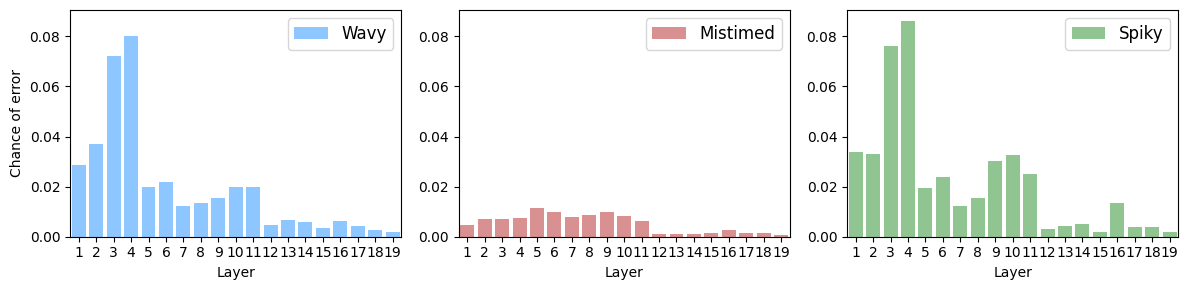

In [32]:
plot_error_by_layer(big_df, True,p_folder, False)

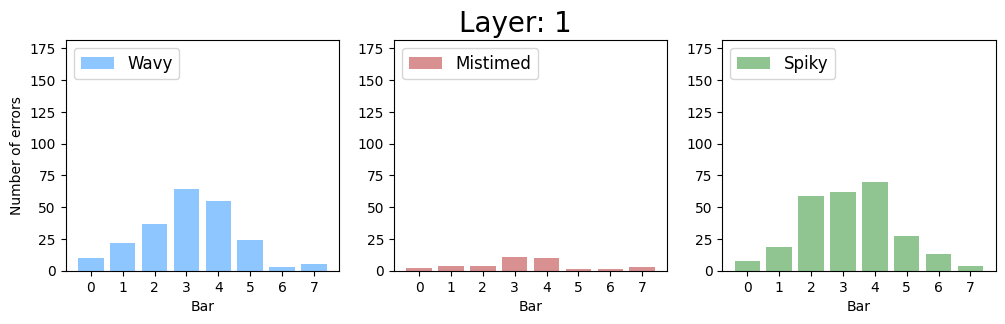

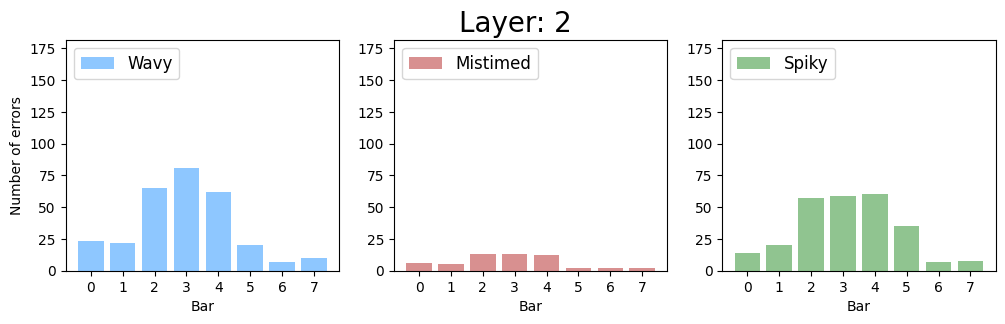

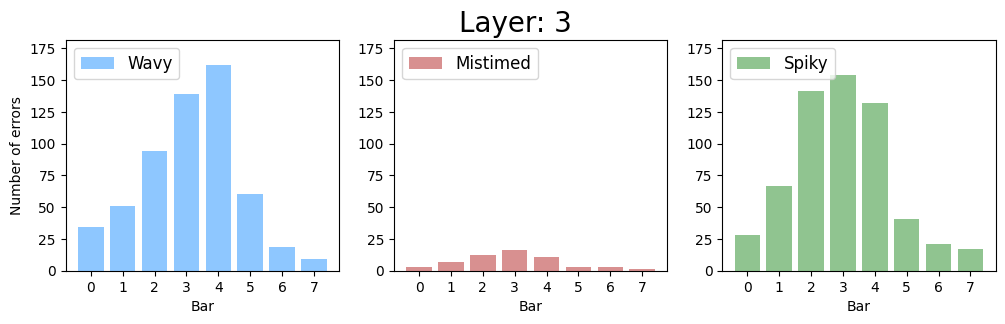

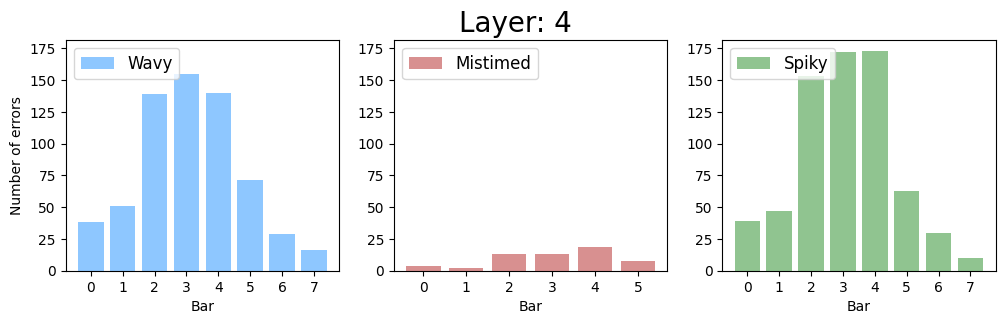

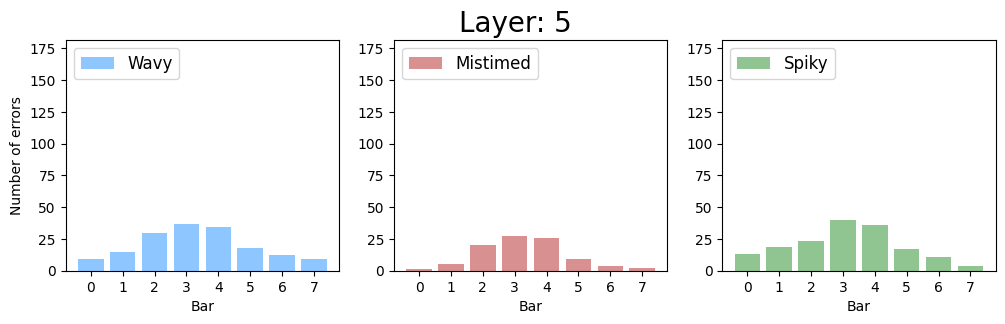

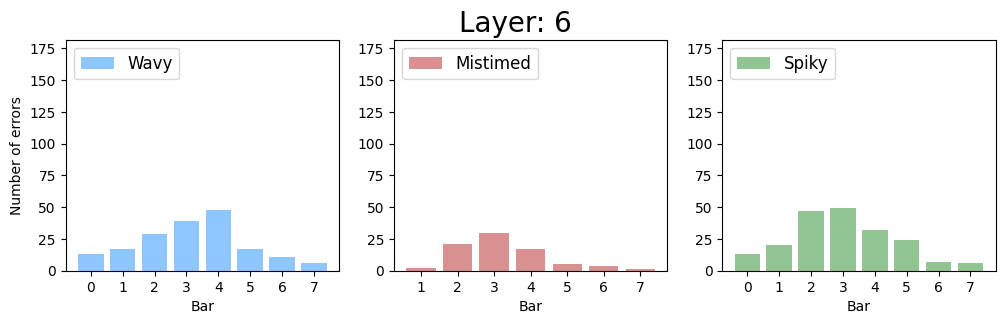

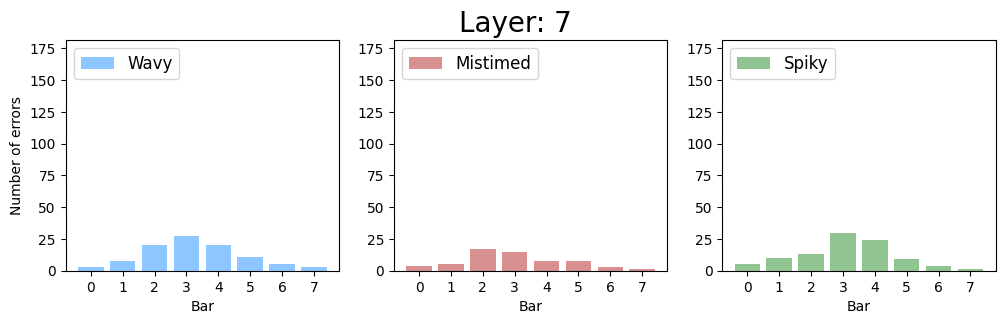

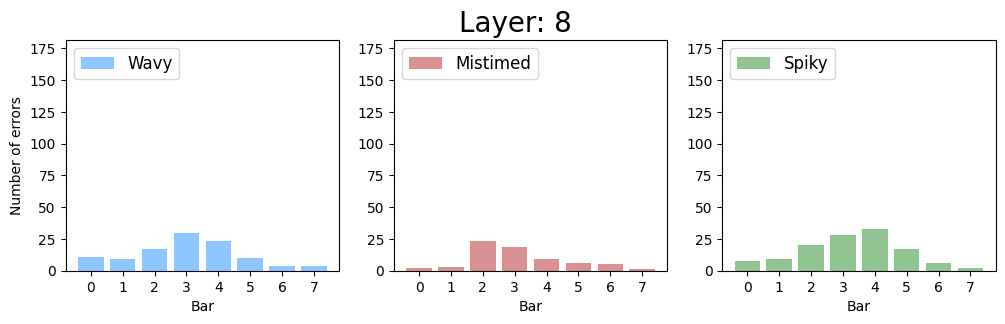

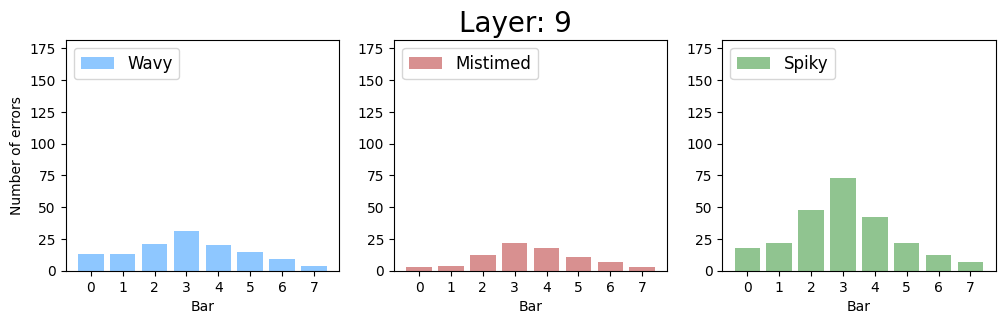

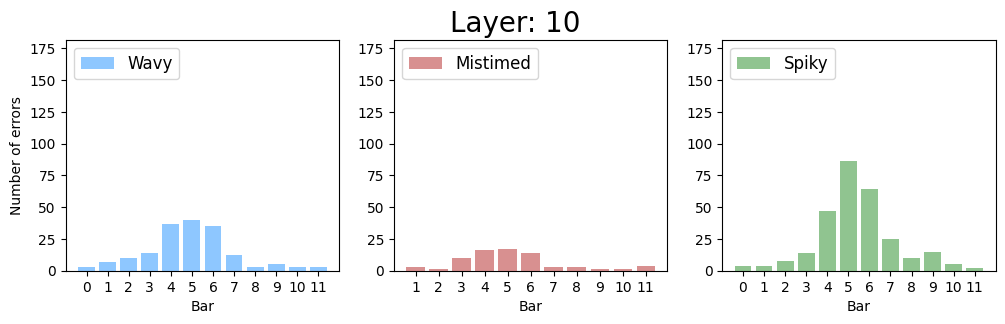

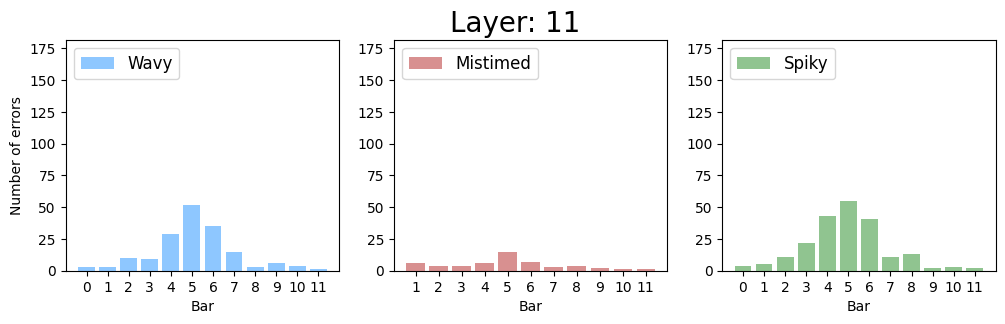

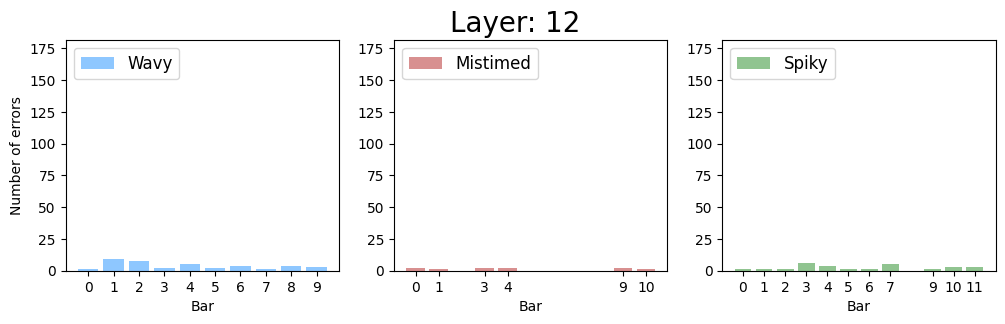

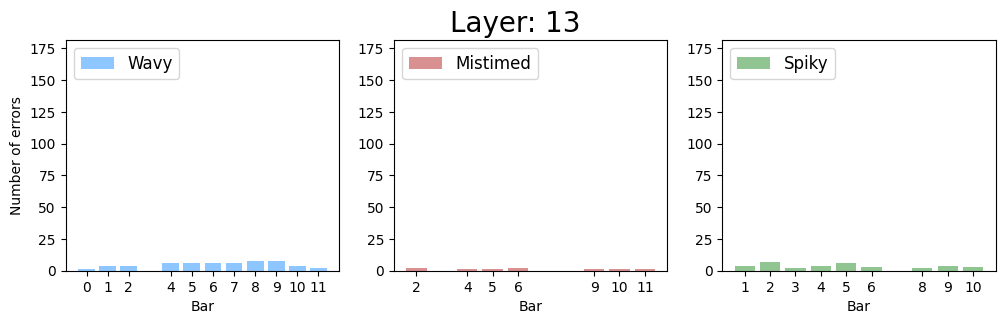

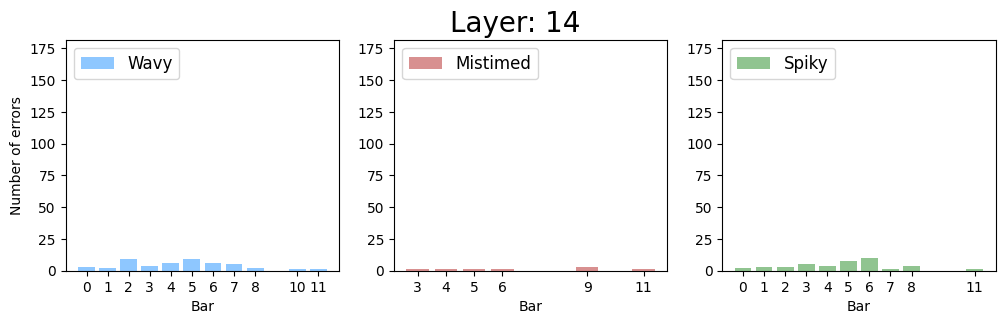

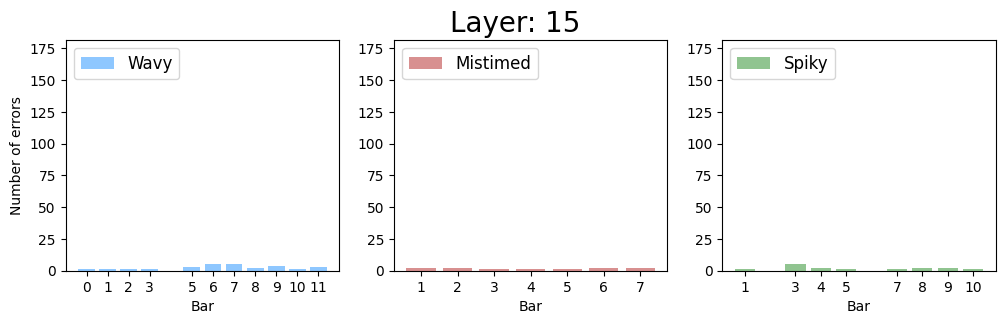

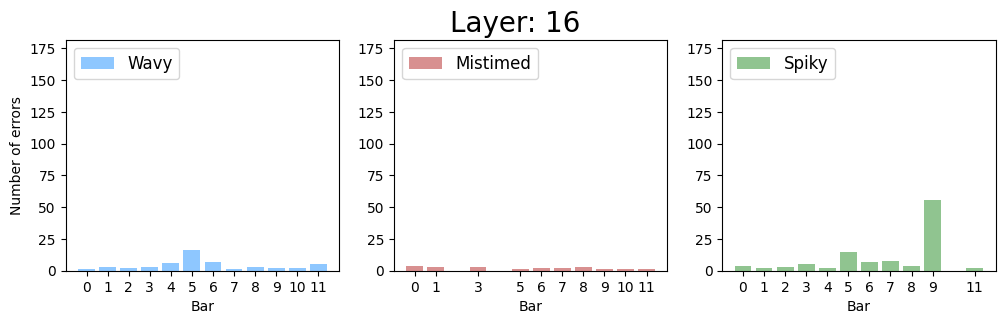

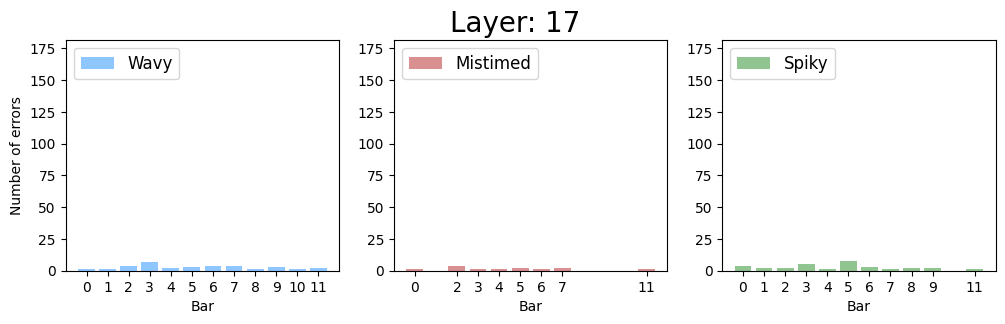

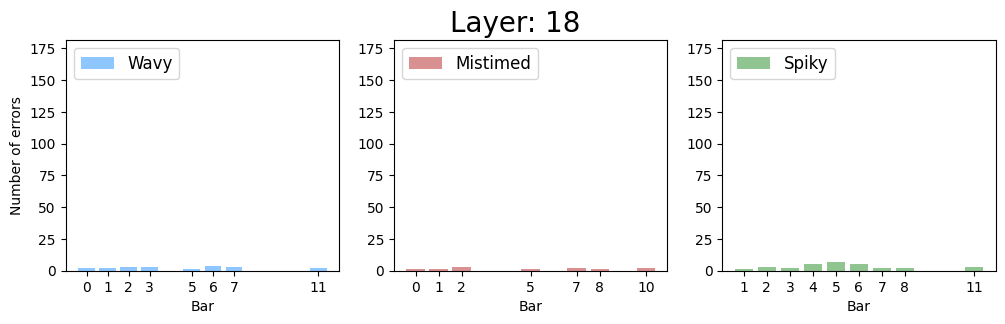

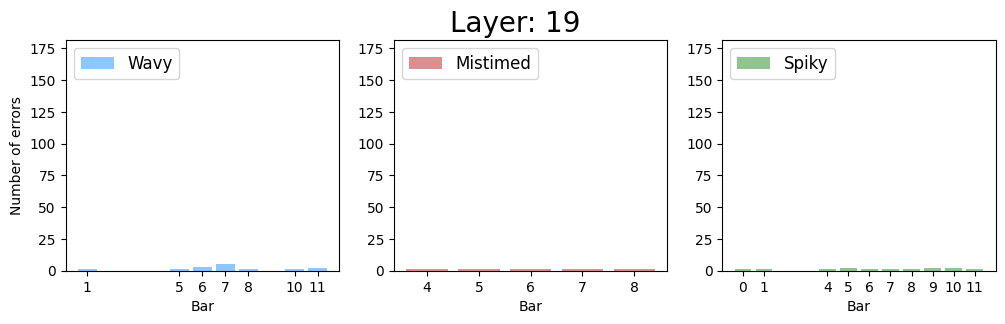

In [33]:
plot_error_by_bar(big_df, False,p_folder, False)

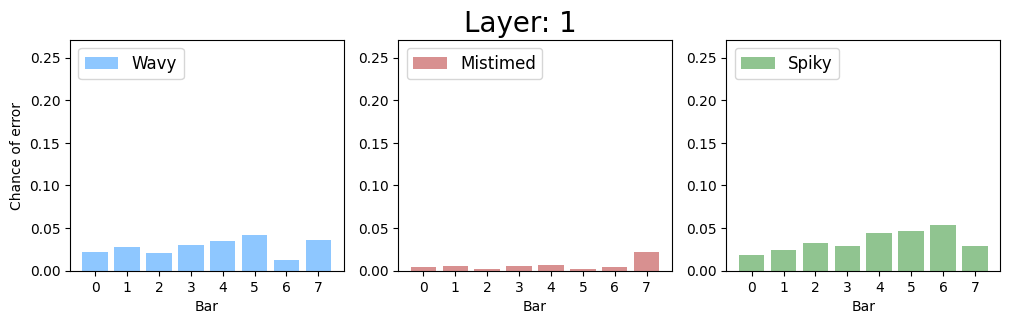

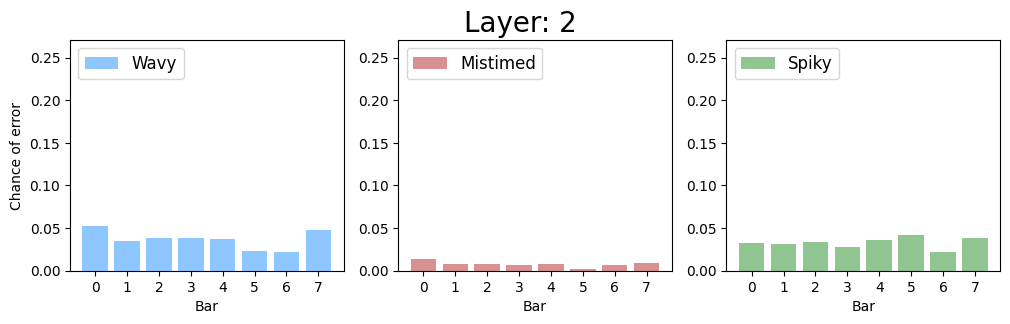

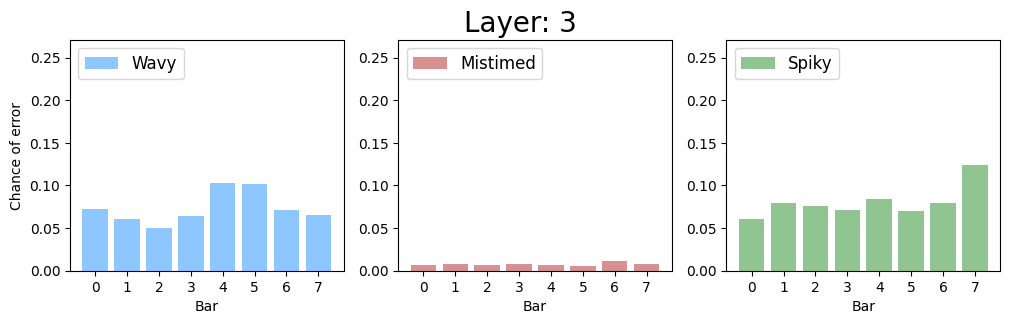

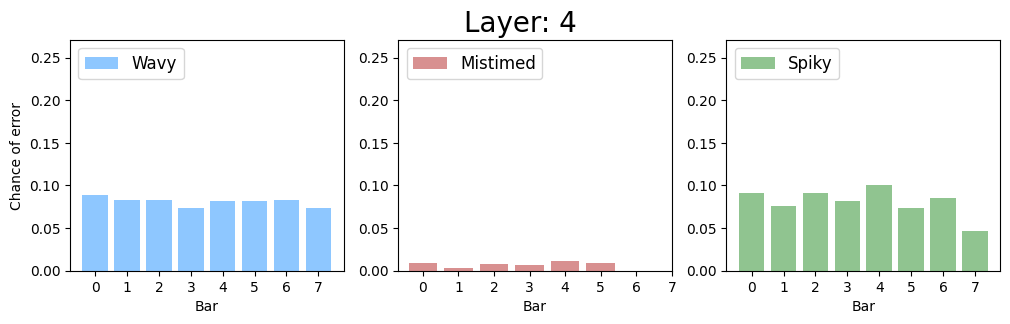

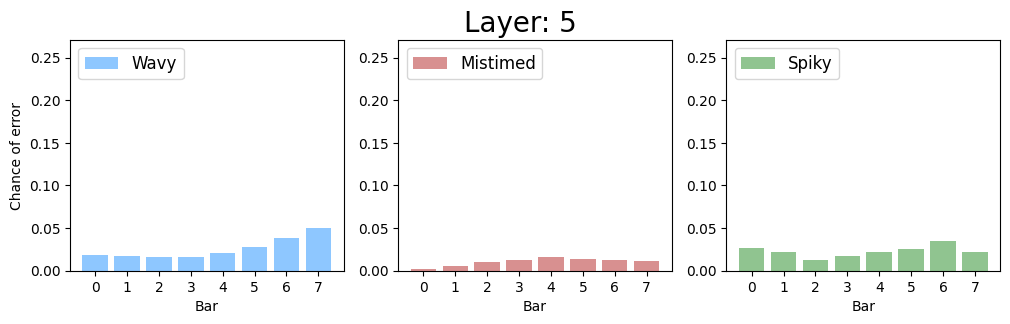

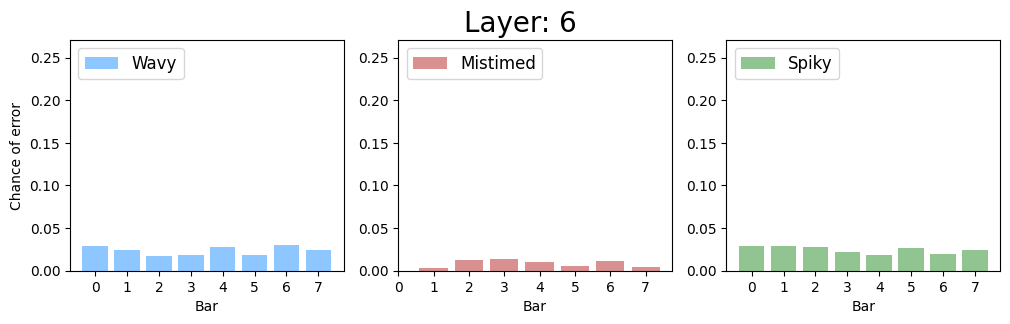

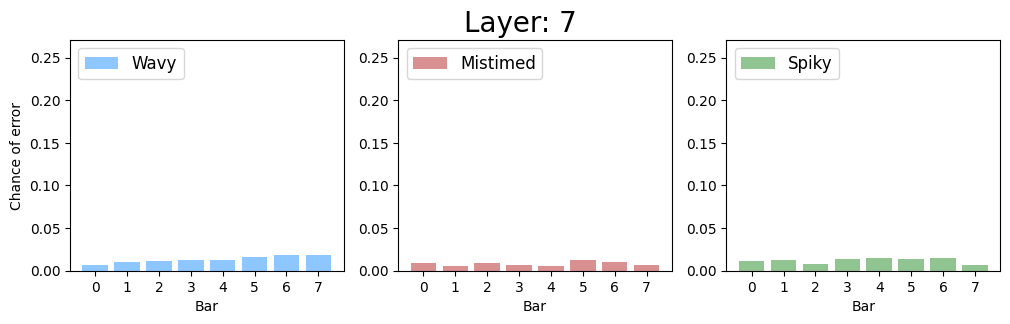

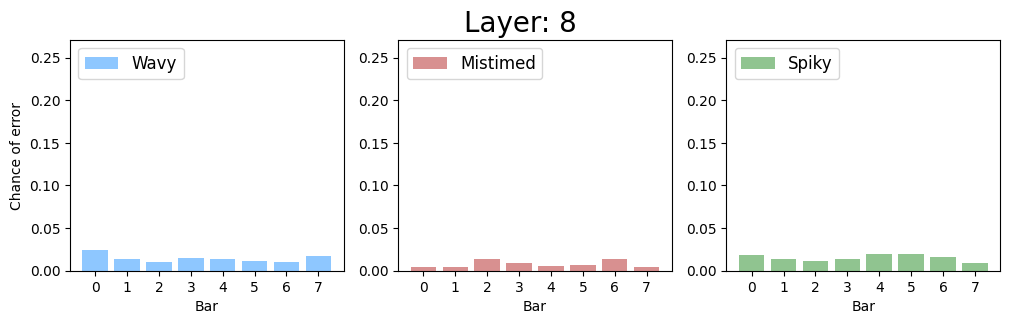

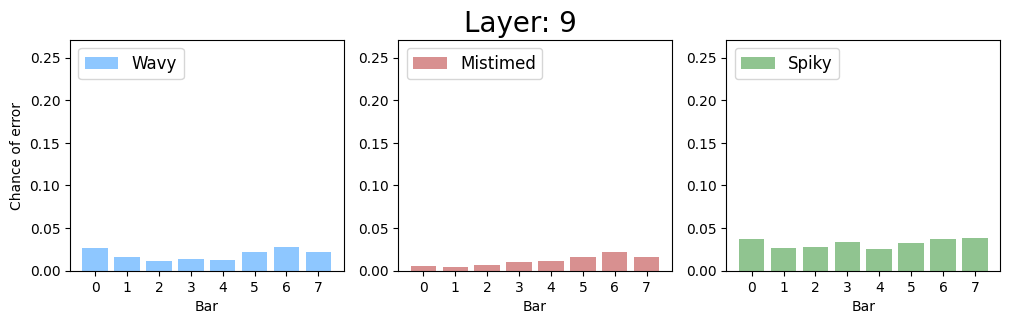

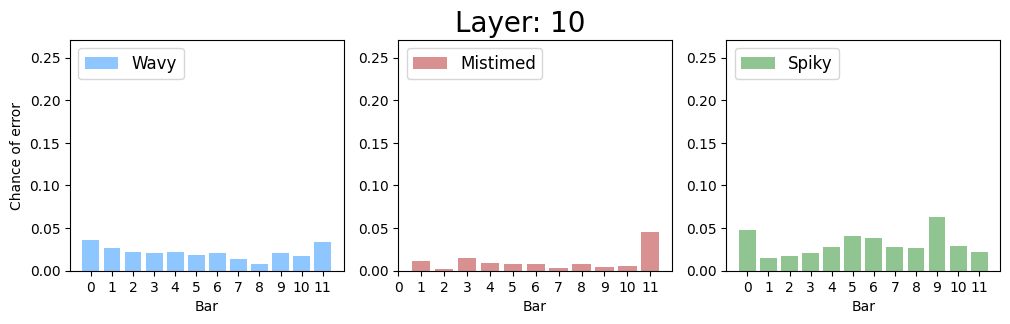

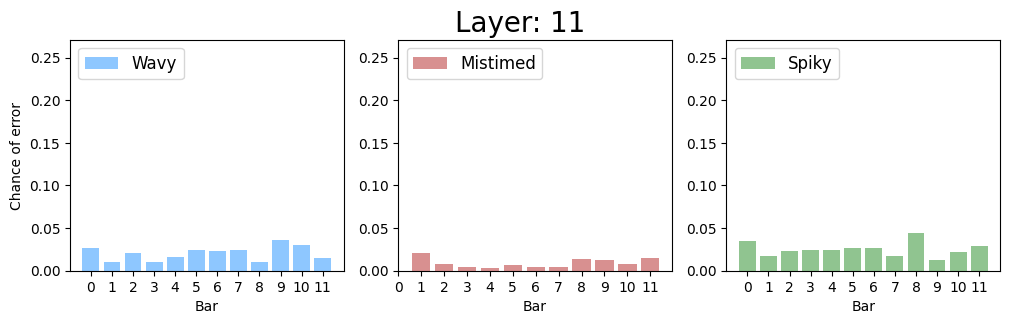

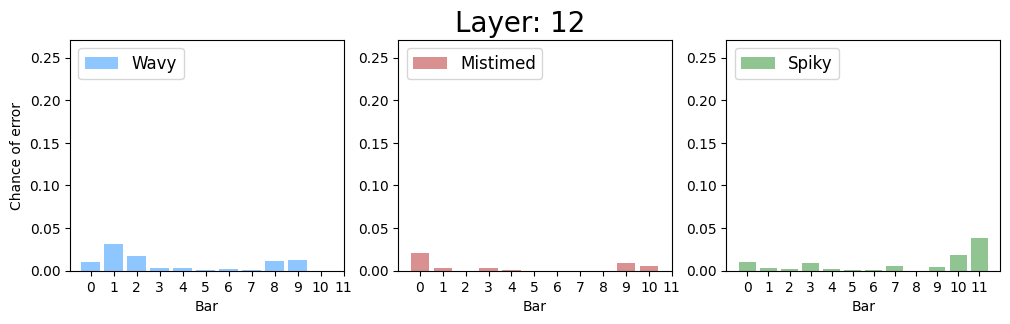

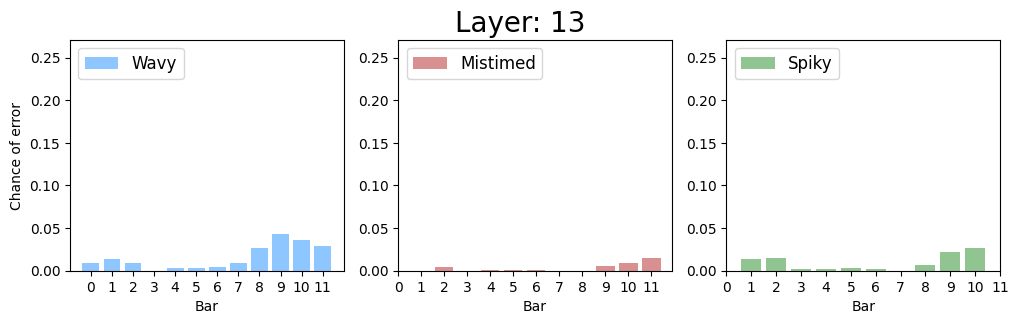

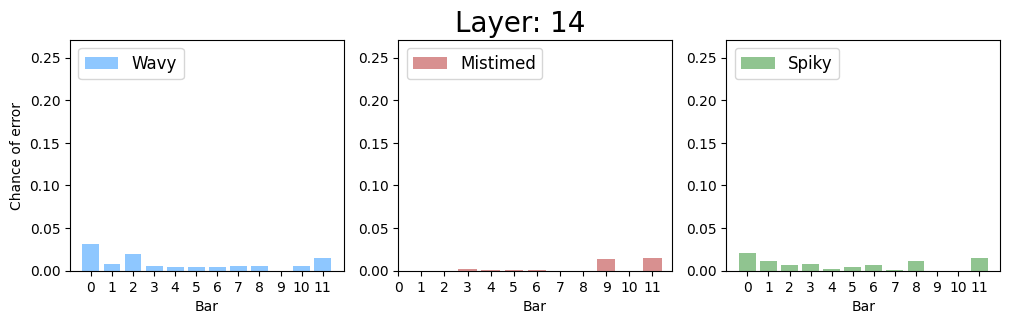

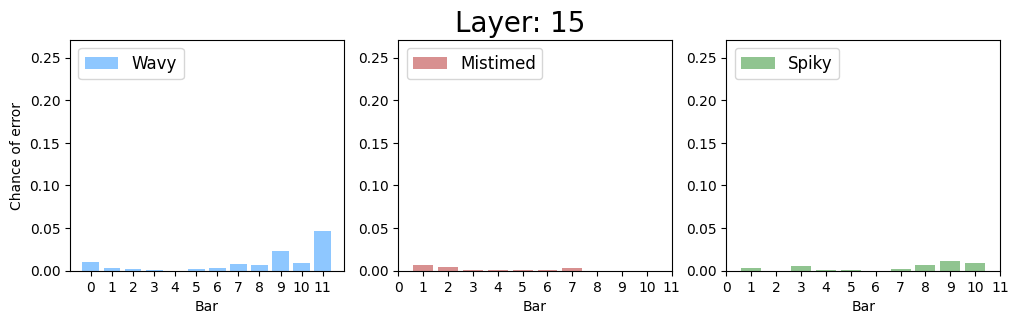

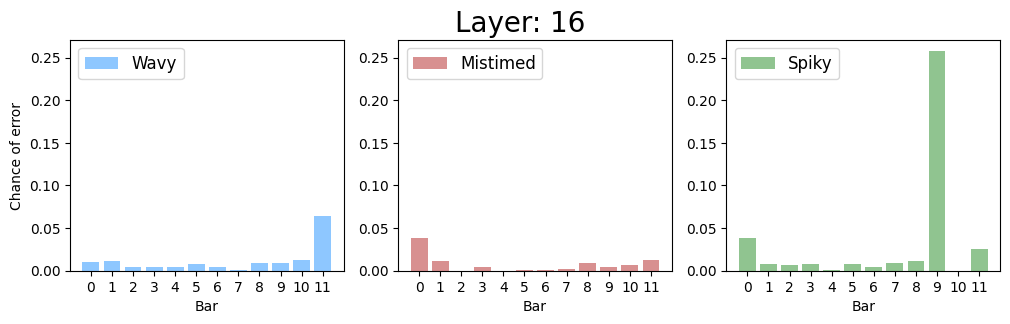

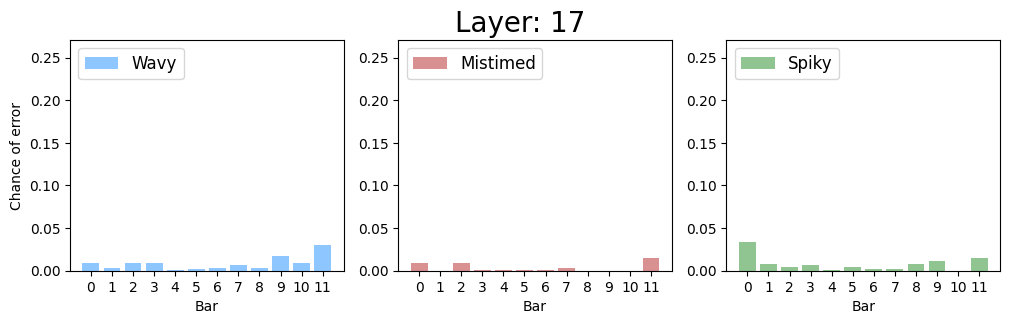

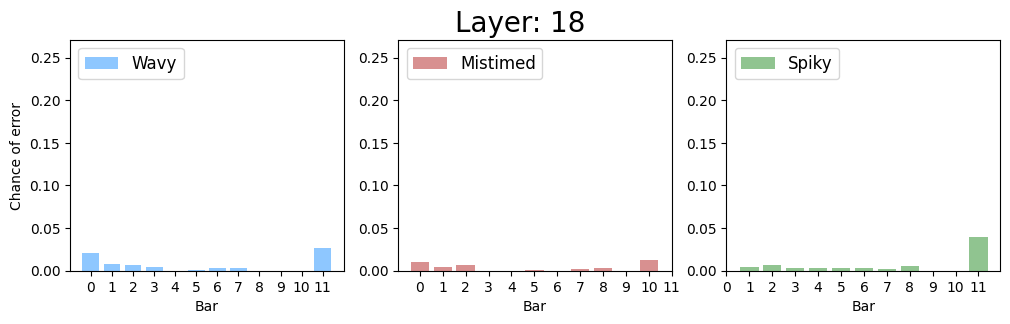

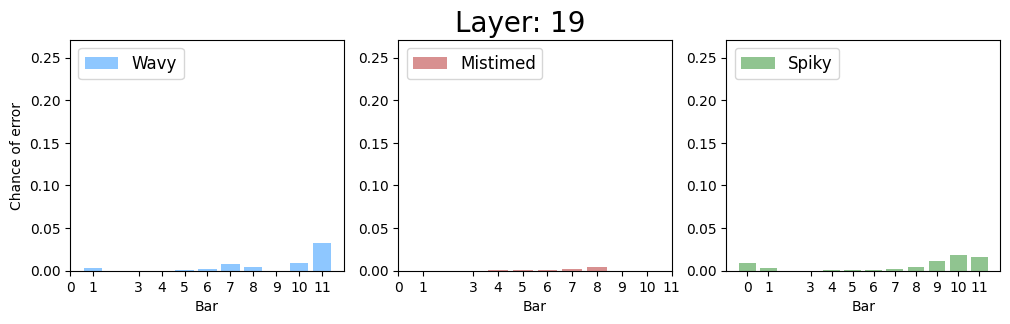

In [34]:
plot_error_by_bar(big_df, True,p_folder, False)